### Example of Multi-label classification with PyTorch: Custom Dataset

Multi-label means that the **same image can have associated several labels**.

In other words: **class are not exclusive**

In this NB we're showing how to prepare the dataset class starting from a CSV containing images'name and labels.

we will be using the **HBKU2019 dataset (from Kaggle)**.

You can take the dataset from here: https://www.kaggle.com/competitions/hbku2019/data

In [1]:
import os
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# globals

SEED = 42

# the directory where you're unzipping
BASE_DIR = "/home/datascience/hbku2019-dataset/"

# file with labels
DATA_CSV = BASE_DIR + 'labels/labels_train.csv'
# dir with images
IMAGE_DIR = BASE_DIR + "imgs/train/"

# Img model input size (chosen fro EffNetB2)
IM_SIDE = 260

# reading the categories
cats = pd.read_csv(BASE_DIR + 'labels/categories.csv', header=None)
cats = list(cats[0])

# Number of classes
N_CLASSES = len(cats)

print(cats)
print(len(cats))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80


#### The class for the custom Dataset

In [3]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, df, image_path, transformations):
        """
        Args:
            df: the dataframe with train or val rows
            image_path: path to dir of images
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transforms = transformations
        
        # store the df
        self.data_info = df
        
        # First column contains the image paths
        self.image_arr = self.data_info.iloc[:, 0].values
  
        # remaining columns are the labels
        self.label_arr = self.data_info.iloc[:, 1:].values

        # Calculate len
        self.data_len = len(self.label_arr)
        
        # image_path
        self.image_path = image_path

    def __getitem__(self, index):
        # Get image name from the array
        image_name = self.image_arr[index]
        
        # Open image
        # to RGB is needed, some imgs are grayscale
        img = Image.open(self.image_path + image_name).convert("RGB")

        if self.transforms is not None:
            # do the resize and normalize (based on ImageNet)
            img = self.transforms(img)
        
        # Get labels of the image
        image_label = self.label_arr[index]

        return (img, image_label)

    def __len__(self):
        return self.data_len

In [4]:
# read all images names and labels
data = pd.read_csv(DATA_CSV, header=None)

# Here we split for train, val datasets
# you should choose if you need stratified split
TEST_FRAC = 0.2
train_df, val_df = train_test_split(data, test_size=TEST_FRAC, random_state=SEED, shuffle=True)

In [5]:
# Transformations on Images

# changed for EffNetB2. You need to change this if you're using a different network (ex: B4)
IMAGE_SIDE = 260

# mean and stds are those from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# in validation we don't do augmentation
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.RandomHorizontalFlip(),
    # added to fight overfitting
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

show_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.ToTensor()
])

# train and validation datasets
train_ds = CustomDatasetFromCSV(train_df, IMAGE_DIR, train_transform)
val_ds = CustomDatasetFromCSV(val_df, IMAGE_DIR, val_transform)

In [6]:
print(f"We have {N_CLASSES} classes...")

print()
print("Datasets:")
print(f"We have {len(train_ds)} samples in train dataset")
print(f"We have {len(val_ds)} samples in validation dataset")

We have 80 classes...

Datasets:
We have 78219 samples in train dataset
We have 19555 samples in validation dataset


#### Look at one example

In [11]:
# have a look at one example
INDEX = 0

# create a dataset with no transforms
show_ds = CustomDatasetFromCSV(train_df, IMAGE_DIR, show_transform)

img, labels = show_ds[INDEX]

In [12]:
print(labels)

# get the names of the classes
labels_indexes = [i for i,l in enumerate(labels) if l > 0]

print()
print("Class names:")
for i in labels_indexes:
    print(cats[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

Class names:
bird
zebra


as we can see, the second piece (labels) is an array, with 80 (num_classes) labels.

torch.Size([260, 260, 3])


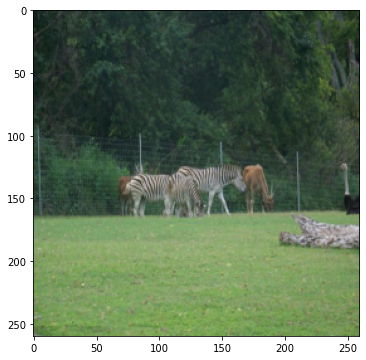

In [13]:
# permute in H, W, C (PyTorch uses C, H, W)
img = img.permute(1, 2, 0)

print(img.shape)
plt.figure(figsize=(6,6))
plt.imshow(img);

#### Data Loaders

In [14]:
# Initialize the dataloaders for training.
BATCH_SIZE = 32

# depends on the num. of available CPU. INcrease till the GPU utilization is enough high (cose to 90% as seen from gpustat)
NUM_WORKERS = 4

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, 
                               num_workers=NUM_WORKERS, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [15]:
train_dl.batch_size

32